In [1]:
#v2
#7/11/2018

dataname="epistroma"

desired_mask_mpp = 16.1 # what we would like to use for finding valid regions of the mask
model_mpp = 2 # MPP of patches to be fed into model

patch_size=300 #size of the tiles to extract and save in the database, must be >= to training size
stride_size = patch_size
test_set_size=.2 # what percentage of the dataset should be used as a held out validation/testing set
resize=1 #resize input images
classes=[0,1] #what classes we expect to have in the data, here we have only 2 classes but we could add additional classes and/or specify an index from which we would like to ignore

#-----Note---
#One should likely make sure that  (nrow+mirror_pad_size) mod patch_size == 0, where nrow is the number of rows after resizing
#so that no pixels are lost (any remainer is ignored)


In [2]:
import torch
import tables

import os,sys
import glob

import PIL
import numpy as np
import scipy

import cv2
import matplotlib.pyplot as plt

from sklearn import model_selection
import sklearn.feature_extraction.image
import random

sys.path.insert(1,'/mnt/data/home/pjl54/WSI_handling')
import wsi

import tqdm

seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed}")

random seed (note down for reproducibility): 4877409286974135937


In [3]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=255) #create an atom to store the filename of the image, just incase we need it later, 

In [27]:
all_files=glob.glob(r'/mnt/data/home/pjl54/pesoProstateSE/imgs/*training_mask.tif')

#create training and validation stages and split the files appropriately between them
phases={}
phases["train"],phases["val"]=next(iter(model_selection.ShuffleSplit(n_splits=1,test_size=test_set_size).split(all_files)))

#specify that we'll be saving 2 different image types to the database, an image and its associated masked
imgtypes=["img","mask"]

In [28]:
for phase in phases.keys(): #now for each of the phases, we'll loop through the files
    print(phase)
    files = [all_files[k] for k in phases[phase]]


    storage={} #holder for future pytables
    rscs = [[] for i in range(0,len(files))]    

    osis = [wsi.wsi(img_fname = file.split('_training_mask.tif')[0]+'.tif',mpp=0.48) for file in files]
    masks = [wsi.wsi(img_fname=file,mpp=0.48) for file in files]

    totals=np.zeros((2,len(classes))) # we can to keep counts of all the classes in for in particular training, since we 
    totals[0,:]=classes               # can later use this information to create better weights

    hdf5_file = tables.open_file(f"./{dataname}_{phase}.pytable", mode='w') #open the respective pytable
    storage["filename"] = hdf5_file.create_earray(hdf5_file.root, 'filename', filenameAtom, (0,)) #create the array for storage

    for index, wsi_img in tqdm.tqdm(enumerate(osis)):

        mask = masks[index]
        stride_size_converted = mask.get_coord_at_mpp(stride_size,input_mpp=model_mpp,output_mpp=desired_mask_mpp)        

        mask_small = mask.get_wsi(desired_mask_mpp)
        mask_small = mask_small[:,:,0]

        mask_small = mask_small[list(range(1,np.shape(mask_small)[0]-1,stride_size_converted)),:]            
        mask_small = mask_small[:,list(range(1,np.shape(mask_small)[1]-1,stride_size_converted))]            

        [rs,cs]=(mask_small>0).nonzero()
        rs = [r*stride_size_converted for r in rs]
        cs = [c*stride_size_converted for c in cs]

        rs = [wsi_img.get_coord_at_mpp(r,output_mpp=wsi_img["mpps"][0],input_mpp=desired_mask_mpp) for r in rs]
        cs = [wsi_img.get_coord_at_mpp(c,output_mpp=wsi_img["mpps"][0],input_mpp=desired_mask_mpp) for c in cs]

#         goods = np.ones(np.shape(rs)[0])
#         for k in range(0,np.shape(rs)[0]):

#             a = wsi_img.get_tile(coords=(cs[k],rs[k]),wh=(1,1),desired_mpp=desired_mask_mpp)
#             if(np.all(a>220)):
#                 goods[k] = False             

        rscs[index]=(cs,rs)            

    patch_counts = [np.shape(k)[1] for k in rscs]        
#     patch_counts[0] = patch_counts[0] - 1   
    adds = [1] + patch_counts
    adds = np.cumsum(adds)
    storage["img"] = np.ones([sum(patch_counts),patch_size,patch_size,3],dtype=np.uint8)
    storage["mask"] = np.ones([sum(patch_counts),patch_size,patch_size],dtype=np.uint8)

    for index, wsi_img in tqdm.tqdm(enumerate(osis)):
        mask_wsi = masks[index]        
        for rcidx in range(0,patch_counts[index]-1):

            mask_coords = tuple([int(mask_wsi.get_coord_at_mpp(c,input_mpp=wsi_img["mpps"][0],output_mpp=mask_wsi["mpps"][0])) for c in (rscs[index][0][rcidx],rscs[index][1][rcidx])])
            mask = mask_wsi.get_tile(desired_mpp=model_mpp,coords=mask_coords,wh=(patch_size,patch_size))        
            mask = mask[:,:,0]
            img = wsi_img.get_tile(desired_mpp=model_mpp,coords=(rscs[index][0][rcidx],rscs[index][1][rcidx]),wh=(patch_size,patch_size))        

            inpaint_mask = np.uint8(mask.copy()==0)            
            mask = cv2.inpaint(mask,inpaint_mask,1,cv2.INPAINT_NS)
            mask = mask-1

            storage["img"][rcidx + adds[index] - 1,:,:,:] = img
            storage["mask"][rcidx + adds[index] - 1,:,:] = mask        

            for i,key in enumerate(classes): #sum the number of pixels, this is done pre-resize, the but proportions don't change which is really what we're after
                    totals[1,i]+=sum(sum(mask==key))

        storage["filename"].append([files[index] for x in range(patch_counts[index]-1)]) #add the filename to the storage array

    #lastely, we should store the number of pixels
    npixels=hdf5_file.create_carray(hdf5_file.root, 'numpixels', tables.Atom.from_dtype(totals.dtype), totals.shape)
    npixels[:]=totals
    hdf5_file.close()

train


49it [00:17,  2.83it/s]
49it [23:10, 28.38s/it]


val


13it [00:04,  2.96it/s]
13it [05:26, 25.14s/it]


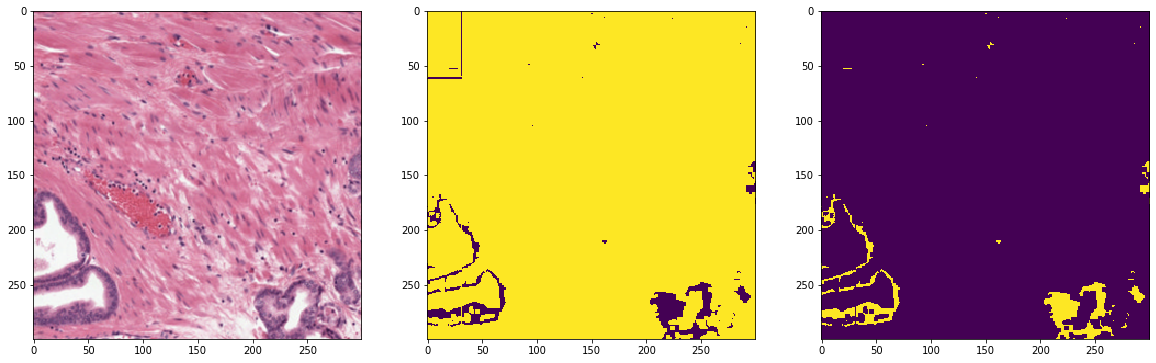

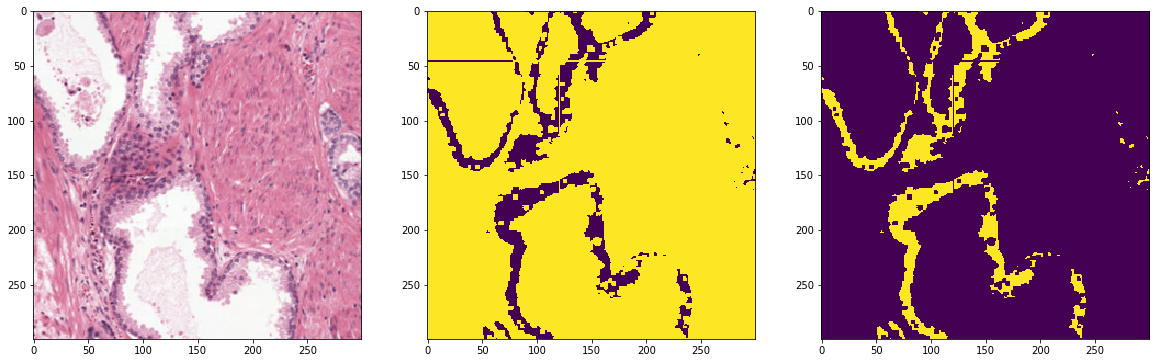

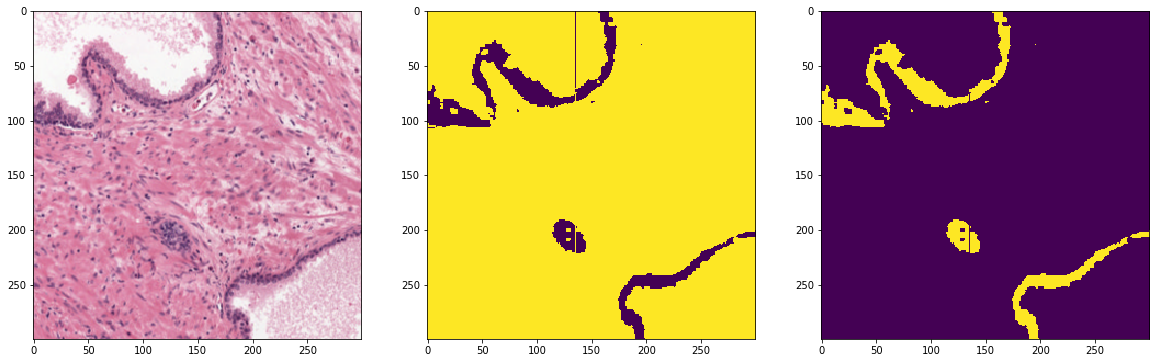

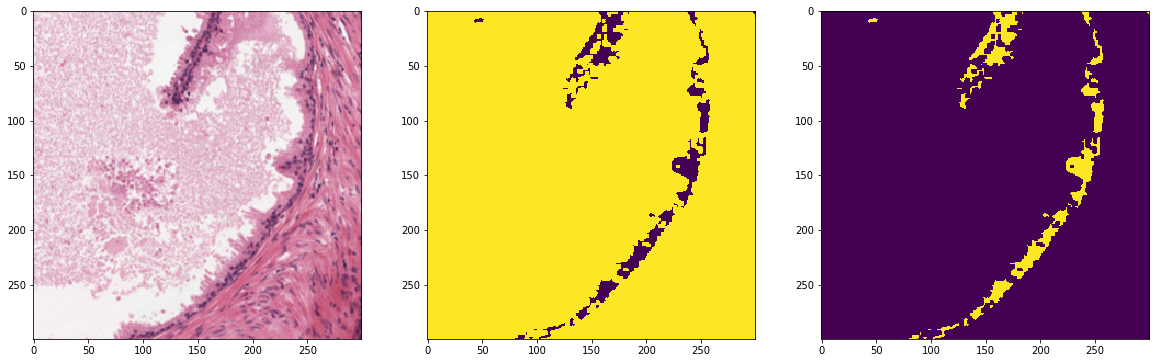

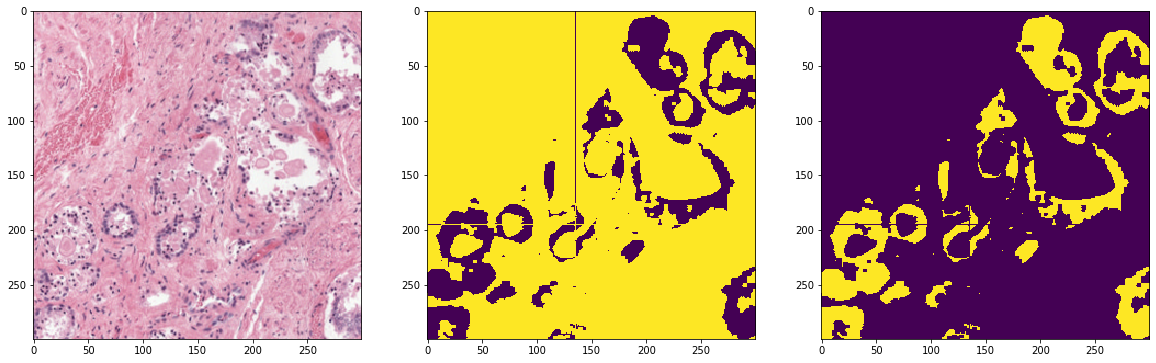

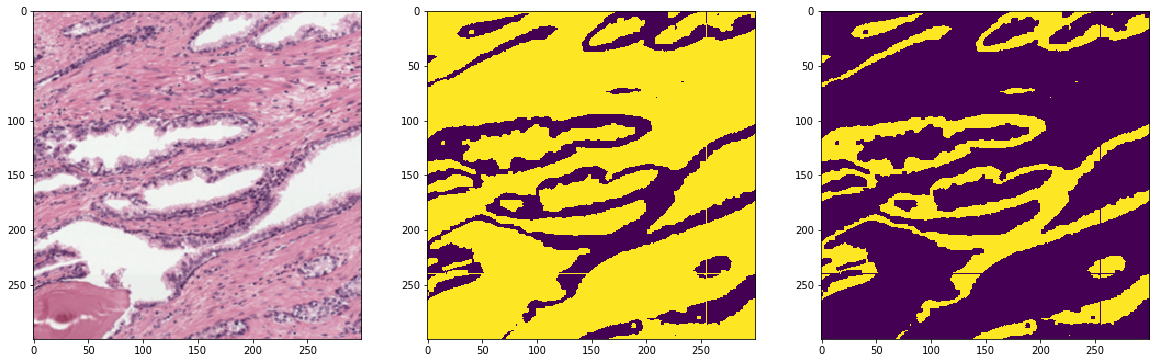

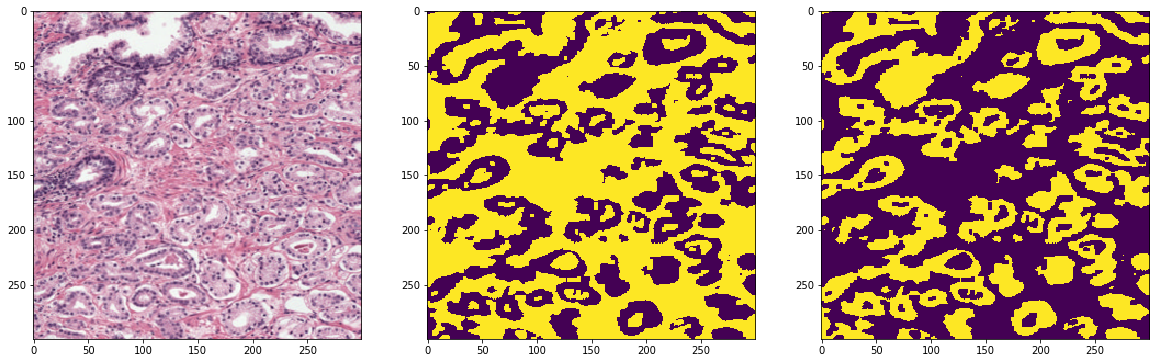

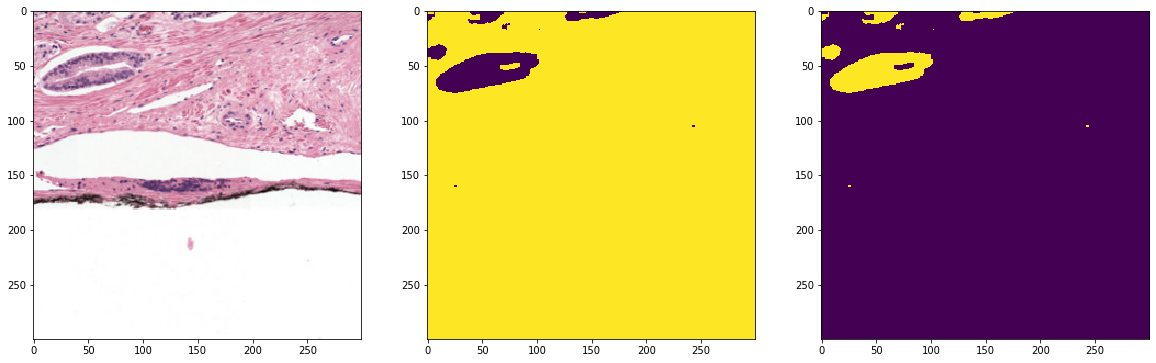

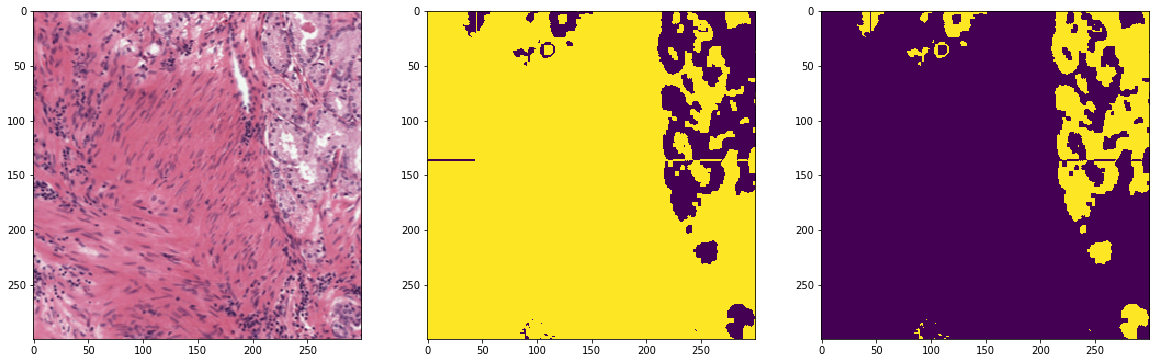

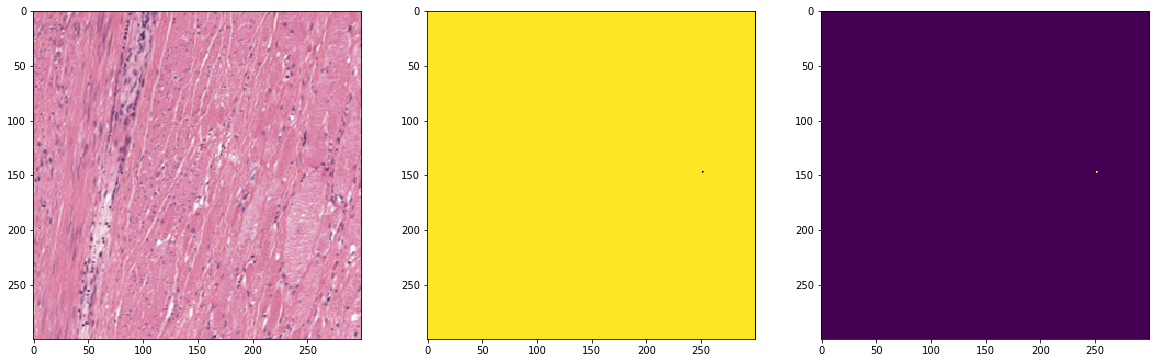

In [25]:
import matplotlib.pyplot as plt

for k in range(1,500,50):
    fig, ax = plt.subplots(1,3,figsize=(20,20))
    ax[0].imshow(storage["img"][k])
    ax[1].imshow(storage["mask"][k]==-0)
    ax[2].imshow(storage["mask"][k]==1)

useful reference
http://machinelearninguru.com/deep_learning/data_preparation/hdf5/hdf5.html